In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, auc, precision_recall_curve
from sklearn.model_selection import train_test_split
import tensorflow as tf
import shap
tf.compat.v1.disable_v2_behavior()


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
pd.options.display.max_rows = 20
pd.options.display.max_columns = 200
data = pd.read_csv('clean_pan.csv', index_col='CASEID')
data = data.drop(['Unnamed: 0'], axis=1)


In [3]:
cat_names = ['PAN_JAUNDICE', 'PAN_BILIARYSTENT', 'PAN_CHEMO', 'PAN_RADIO', 'PAN_INTRA_ANTIBIOTICS',  'PAN_DUCTSIZE', 'PAN_GLANDTEXT', 'PAN_RECONSTRUCTION',  'PAN_DRAINS', 'PAN_DRAINS_TYPE', 'PAN_DRAINSYS_TYPE', 'PAN_DRAINSYS_SUCTN', 'PAN_RESECTION']

cont_names = ['PAN_AMYLASE_POD1']
y_names=['PAN_FISTULA']

features = cat_names + cont_names + y_names
data = data[features]

columns = {'PAN_JAUNDICE':'Jaundice', 'PAN_BILIARYSTENT':'Biliary stent', 'PAN_CHEMO':'Chemotherapy', 'PAN_RADIO':'Radiation therapy', 'PAN_INTRA_ANTIBIOTICS':'Antibiotic',  'PAN_DUCTSIZE':'Duct size', 'PAN_GLANDTEXT':'Gland texture', 'PAN_RECONSTRUCTION':'Reconstruction',  'PAN_DRAINS':'Drains', 'PAN_DRAINS_TYPE':'Drain location', 'PAN_DRAINSYS_TYPE':'Drain type', 'PAN_DRAINSYS_SUCTN':'Drain suction', 'PAN_RESECTION':'Vascular resection','PAN_AMYLASE_POD1':'Drain amylase (POD1)'}


col = {value : key for key, value in columns.items()}


In [4]:
data.rename(columns=columns, errors='raise', inplace=True)

In [5]:
X = data.drop(['PAN_FISTULA'], axis=1)
y = data['PAN_FISTULA']

In [6]:

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [7]:
input_shape = [X.shape[1]]
model4 = tf.keras.models.Sequential()
model4.add(tf.keras.layers.Flatten(input_shape=input_shape))
model4.add(tf.keras.layers.BatchNormalization())
for _ in range(2):
    model4.add(tf.keras.layers.Dense(1000))
    model4.add(tf.keras.layers.BatchNormalization())
    model4.add(tf.keras.layers.Dropout(0.8))
    model4.add(tf.keras.layers.Activation("relu"))
model4.add(tf.keras.layers.Dense(1, activation="sigmoid"))

opt = tf.keras.optimizers.Adam(learning_rate=3e-4)

metrics = [tf.keras.metrics.Recall(name='Sensitivity'), tf.keras.metrics.TrueNegatives(name='tn'), tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.AUC(name='prc', curve='PR')]

model4.compile(
    optimizer=opt,
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=metrics,)

early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.00001,
    restore_best_weights=True,)
model4.fit(X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=1024,
    epochs=200,
    callbacks=[early_stopping])


Instructions for updating:
Colocations handled automatically by placer.
Train on 18586 samples, validate on 4647 samples
Epoch 1/200
16384/18586 [=========================>....] - ETA: 0s - loss: 0.7778 - Sensitivity: 0.3349 - tn: 9761.0000 - auc: 0.5455 - prc: 0.1853

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


18586/18586 [==============================] - 1s 66us/sample - loss: 0.7621 - Sensitivity: 0.3177 - tn: 11343.0000 - auc: 0.5477 - prc: 0.1866 - val_loss: 0.6056 - val_Sensitivity: 0.1591 - val_tn: 3725.0000 - val_auc: 0.6807 - val_prc: 0.2964
Epoch 2/200
18586/18586 [==============================] - 0s 10us/sample - loss: 0.6284 - Sensitivity: 0.1436 - tn: 14056.0000 - auc: 0.5798 - prc: 0.2109 - val_loss: 0.5473 - val_Sensitivity: 0.1110 - val_tn: 3803.0000 - val_auc: 0.6889 - val_prc: 0.3042
Epoch 3/200
18586/18586 [==============================] - 0s 9us/sample - loss: 0.6170 - Sensitivity: 0.1452 - tn: 14225.0000 - auc: 0.5918 - prc: 0.2241 - val_loss: 0.5399 - val_Sensitivity: 0.1003 - val_tn: 3812.0000 - val_auc: 0.6931 - val_prc: 0.3077
Epoch 4/200
18586/18586 [==============================] - 0s 9us/sample - loss: 0.6017 - Sensitivity: 0.1507 - tn: 14202.0000 - auc: 0.6015 - prc: 0.2305 - val_loss: 0.5344 - val_Sensitivity: 0.0909 - val_tn: 3822.0000 - val_auc: 0.6843 - va

In [8]:
X_train.shape

(18586, 14)

In [9]:
X_valid.shape

(4647, 14)

keras is no longer supported, please use tf.keras instead.


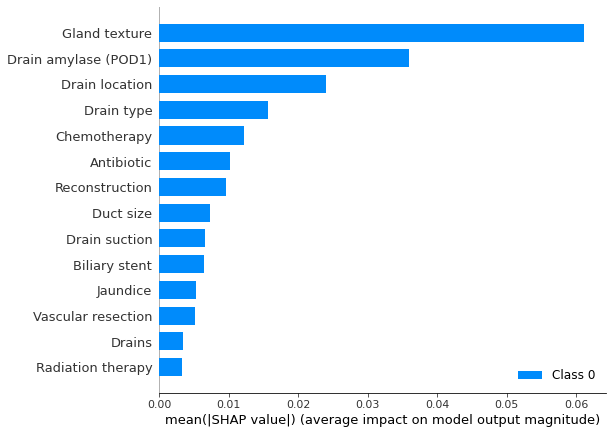

In [10]:
import shap
tf.config.list_physical_devices('GPU')
explainer = shap.DeepExplainer(model4, X_train.sample(n=4000))
shap_values = explainer.shap_values(X_valid.sample(n=4000).values)
shap.summary_plot(shap_values, X_valid.sample(n=4000))

In [11]:
shap_values[0].shape
vals = np.abs(shap_values[0]).mean(0)
feature_names = X_train.columns
feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)
feature_importance.head(10)

,col_name,feature_importance_vals
6,Gland texture,0.061181
13,Drain amylase (POD1),0.035899
9,Drain location,0.023997
10,Drain type,0.015578
2,Chemotherapy,0.012203
4,Antibiotic,0.010177
7,Reconstruction,0.009652
5,Duct size,0.007254
11,Drain suction,0.006629
1,Biliary stent,0.006484


In [12]:
pan_feature_importance = feature_importance[feature_importance['col_name'].str.contains('PAN')]

cat_names = ['PAN_JAUNDICE', 'PAN_BILIARYSTENT', 'PAN_CHEMO', 'PAN_RADIO', 'PAN_INTRA_ANTIBIOTICS',  'PAN_DUCTSIZE', 'PAN_GLANDTEXT', 'PAN_RECONSTRUCTION',  'PAN_DRAINS', 'PAN_DRAINS_TYPE', 'PAN_DRAINSYS_TYPE', 'PAN_DRAINSYS_SUCTN', 'PAN_RESECTION', 
            ]
cont_names = ['PAN_AMYLASE_POD1']

features = cat_names + cont_names


In [13]:
pan_feature_importance.head(20)

,col_name,feature_importance_vals


names = {value : key for key, value in columns.items()}

mapping = {'PAN_JAUNDICE':'Jaundice', 'PAN_BILIARYSTENT':'Biliary stent', 'PAN_CHEMO':'Chemotherapy', 'PAN_RADIO':'Radiation therapy', 'PAN_INTRA_ANTIBIOTICS':'Antibiotic',  'PAN_DUCTSIZE':'Duct size', 'PAN_GLANDTEXT':'Gland texture', 'PAN_RECONSTRUCTION':'Reconstruction',  'PAN_DRAINS':'Drains', 'PAN_DRAINS_TYPE':'Drain location', 'PAN_DRAINSYS_TYPE':'Drain type', 'PAN_DRAINSYS_SUCTN':'Drain suction', 'PAN_RESECTION':'Vascular resection','PAN_AMYLASE_POD1':'Drain amylase (POD1)'}


f= lambda x: mapping.get(x, x)

mapping = {'PAN_JAUNDICE':'Jaundice', 'PAN_BILIARYSTENT':'Biliary stent', 'PAN_CHEMO':'Chemotherapy', 'PAN_RADIO':'Radiation therapy', 'PAN_INTRA_ANTIBIOTICS':'Antibiotic',  'PAN_DUCTSIZE':'Duct size', 'PAN_GLANDTEXT':'Gland texture', 'PAN_RECONSTRUCTION':'Reconstruction',  'PAN_DRAINS':'Drains', 'PAN_DRAINS_TYPE':'Drain location', 'PAN_DRAINSYS_TYPE':'Drain type', 'PAN_DRAINSYS_SUCTN':'Drain suction', 'PAN_RESECTION':'Vascular resection','PAN_AMYLASE_POD1':'Drain amylase (POD1)'}

hep_feature_importance = feature_importance[feature_importance['col_name'].str.contains('HEP')]
hep_feature_importance.head(20)


In [16]:
feature_importance.to_excel('shap_pan.xlsx')


In [18]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)

coef = lr.coef_
coef.shape
ors = np.exp(coef)
ors = ors.squeeze()


In [23]:
or_df = pd.DataFrame(list(zip(feature_names, ors)),columns=['col_name','odds ratio'])
or_df['diff'] = abs(1 - or_df['odds ratio'])
pan_ors = or_df.sort_values(by='diff', ascending=False)
pan_ors.head(10)

,col_name,odds ratio,diff
6,Gland texture,1.374893,0.374893
2,Chemotherapy,0.765040,0.234960
9,Drain location,0.782095,0.217905
12,Vascular resection,0.835935,0.164065
10,Drain type,0.862717,0.137283
3,Radiation therapy,0.876673,0.123327
4,Antibiotic,0.884218,0.115782
5,Duct size,0.913628,0.086372
0,Jaundice,0.920526,0.079474
8,Drains,0.954089,0.045911


In [25]:
pan_ors.to_excel('ors_pan.xlsx')